# PlantVillage dataset

In [26]:
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch, time

import matplotlib.pyplot as plt
import numpy as np


# Transformers 

In [27]:
from torchvision import transforms as T

TRAIN_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])

VAL_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


TEST_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


# Train-Val-Test.... Split the PlantVillage dataset

In [28]:
# import splitfolders
# input_folder = './PlantVillage/'
# splitfolders.ratio(input_folder, output='./NewPlantVillageFolder', seed=24, ratio=(.7, .2, .1), group_prefix=None)

In [29]:

train_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/train/', transform=TRAIN_TRANSFORMERS)
val_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/val/', transform=VAL_TRANSFORMERS)
tes_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/test/', transform=TEST_TRANSFORMERS)


## In our train_data_loader dataset we have ( 701, 701, 106 ) which is unbalanced ....

In [30]:

train_data_loader = data.DataLoader(train_data, shuffle=True, batch_size=32, num_workers=4)
#we're doubling it by 2 on the val_ data_loader cuz we're not goint to calculate the grediant, 
# so we do not use as much as mimory as the train_data_loader
val_data_loader  = data.DataLoader(val_data, shuffle=False, batch_size=64, num_workers=4) 
test_data_loader = data.DataLoader(tes_data, shuffle=False, batch_size=64, num_workers=4)

print(len(train_data))
print(len(val_data))
print(len(tes_data))

print('====================')

print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

1506
430
216
48
7
4


In [31]:
images, labels = next(iter(train_data_loader))
images.shape

torch.Size([32, 3, 224, 224])

In [32]:
train_data.classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [33]:
train_data.class_to_idx

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

# show_transformed_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 3, 224, 224]) tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0])
labels >>  tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0])


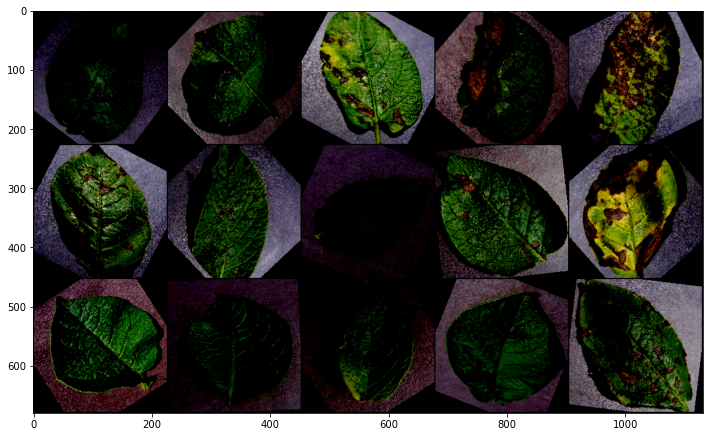

In [34]:
def show_transformed_images(dataset):
    loader = data.DataLoader(train_data, batch_size=15, shuffle=True)
    batch = next(iter(loader))
    images, targets = batch

    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    print(images.shape, targets)
    print('labels >> ', targets)
    
    
show_transformed_images(train_data_loader)

In [10]:
batch = next(iter(train_data_loader))
imgs, targets = batch
imgs.shape, targets

(torch.Size([32, 3, 224, 224]),
 tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
         1, 2, 0, 1, 1, 1, 1, 0]))

In [11]:
# (n-f+2p/s)+1 * (n-f+2p/s)+1
print((256 - 3 +(2*1)/1 + 1))

256.0


# Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Step 2: Define the CNN architecture
#### Parameters
input_size = 3
num_classes = 3
num_epoch  = 3  
batch_size = 32
learning_rate = 0.01


class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        #self.dropout1 = nn.Dropout(0.25) I do not think we need drop out in this case
        
        #self.fc1 = nn.Linear(in_features=50176, out_features=32)
        #self.fc2 = nn.Linear(in_features=32, out_features=3)
        #self.fc1 = nn.Linear(in_features=16*64*64, out_features=3) # if the img size is (256, 256)
        self.fc2 = nn.Linear(in_features=16*56*56, out_features=3)  # if we resize it to (224, 224)

        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        #self.dropout1(x)
        
        #### Flatten ---> from 3d to 1d tensor
        #print('Three-d tensor', x.shape) # torch.Size([4, 16, 64, 64])
        #print('Three-d tensor', x.shape) torch.Size([32, 16, 56, 56])
        
        out = out.reshape(out.shape[0], -1)
        #print('One-d tensor', x.shape) #torch.Size([4, 65536])
        #print('One-d tensor', x.shape) #torch.Size([32, 50176])

        #out = self.fc1(out)
        out = self.fc2(out)
        return out
    
my_cnn = CNN()
my_cnn   

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=50176, out_features=3, bias=True)
)

In [36]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_cnn.parameters(), lr=0.001)

In [14]:
16*56*56

50176

# Loss-error

In [15]:
allLosses = []
ix = 0
for images, labels in train_data_loader:
    score = my_cnn(images)
    loss = loss_function(score, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    allLosses.append(loss.item())
    ix+=1
    
    if ix % 10 == 0:
        print(f"Loss-error: {loss}")
        
print(' >> finish Runnin ...  ')

Loss-error: 1.2346216440200806
Loss-error: 0.5078806281089783
Loss-error: 0.4510020613670349
Loss-error: 0.3001207411289215
 >> finish Runnin ...  


Text(0.5, 0, 'epoch')

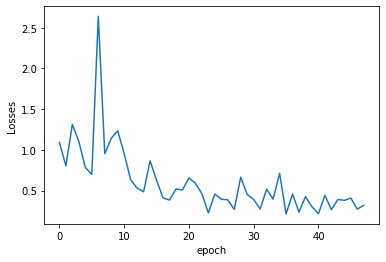

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_data_loader)), allLosses)
plt.ylabel('Losses')
plt.xlabel('epoch')

# ##########################################################################                                          train  model


In [17]:

train_accuracy = []
train_loss = []

for epoch in range(4):  # repeat loop over the dataset multiple times
    
    print(f"Running epoch... {epoch + 1 }")
    
    corr = 0
    n_samples = 0
    ix = 0
    running_loss_train = 0
    
    for images, labels in train_data_loader:

        score_pred = my_cnn(images)        
        loss = loss_function(score_pred, labels)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        ############# Accu ########################
        _, predictions = torch.max(score_pred, 1)
        good_pred = (predictions == labels).sum().item()
        corr += good_pred
        n_samples += labels.size(0)
        
        train_accuracy.append(100 * corr / n_samples)
        ix += 1
        
        if ix % 10 == 0:
            print(f"Loss-Error: >>>> {loss.item()}")
        
    ############# loss error ########################
        running_loss_train += loss.item() 
    epoch_loss_train = running_loss_train / len(train_data_loader)
    train_loss.append(epoch_loss_train)

        
    print(f" --->> Accuracy on Training-data -->> : {100 * corr / n_samples}")

Running epoch... 1
Loss-Error: >>>> 0.2922995090484619
Loss-Error: >>>> 0.21147610247135162
Loss-Error: >>>> 0.5100979208946228
Loss-Error: >>>> 0.20940527319908142
 --->> Accuracy on Training-data -->> : 87.51660026560425
Running epoch... 2
Loss-Error: >>>> 0.19809649884700775
Loss-Error: >>>> 0.15569819509983063
Loss-Error: >>>> 0.13791979849338531
Loss-Error: >>>> 0.1750069260597229
 --->> Accuracy on Training-data -->> : 93.89110225763612
Running epoch... 3
Loss-Error: >>>> 0.15584303438663483
Loss-Error: >>>> 0.1851768046617508
Loss-Error: >>>> 0.15258432924747467
Loss-Error: >>>> 0.09612371027469635
 --->> Accuracy on Training-data -->> : 94.02390438247012
Running epoch... 4
Loss-Error: >>>> 0.16855476796627045
Loss-Error: >>>> 0.08686535060405731
Loss-Error: >>>> 0.09157579392194748
Loss-Error: >>>> 0.033592622727155685
 --->> Accuracy on Training-data -->> : 93.42629482071713


# ##########################################################################  Validatde  model

In [18]:
# Step 5: Validating the model using the val_data_loader set
val_loss = []
val_acc = []
iters = []

with torch.no_grad():
    corr_pred = 0
    n_samples = 0
    running_loss_val = 0
    
    for x, y in val_data_loader:
        val_scores = my_cnn(x)
        valLoss = loss_function(val_scores, y)
        
        _, predictions = torch.max(val_scores, 1)
        goodPred = (predictions == y).sum().item()
        corr_pred += goodPred
        n_samples += y.size(0)

        val_acc.append(100 * corr_pred / n_samples)
        val_loss.append(valLoss.item())
        
    ############# loss error ########################   
        running_loss_val += loss.item()
    epoch_loss_val = running_loss_val / len(val_data_loader)
    val_loss.append(epoch_loss_val)
        
    print(f" >>> Accuracy ON val-data >> : {100 * corr_pred / n_samples}")
    print(f'Loss-Error', val_loss)

 >>> Accuracy ON val-data >> : 96.97674418604652
Loss-Error [0.133505716919899, 0.06127168983221054, 0.15681153535842896, 0.05255760997533798, 0.04909151792526245, 0.06678570806980133, 0.1174573078751564, 0.21127982437610626]


# ##########################################################################                                           Test model
Test the model

In [19]:
# Step 5: Test the model using the test_data_loader set
test_loss = []
test_acc = []

with torch.no_grad():
    
    corr_predTest = 0
    n_samplesTest = 0
    running_loss = 0
    
    for x, y in test_data_loader:
        test_scores = my_cnn(x)
        testLoss = loss_function(test_scores, y)
        test_loss.append(testLoss.item())
        
        _, predictions = torch.max(test_scores, 1)
        goodPredTest = (predictions == y).sum().item()
        corr_predTest += goodPredTest
        n_samplesTest += y.size(0)
        
        test_acc.append(100 * corr_predTest / n_samplesTest)

        ############# loss error ########################
        running_loss += loss.item() 
    epoch_loss = running_loss / len(test_data_loader)
    test_loss.append(epoch_loss)

    print(f" >>> Accuracy ON test-data-loader >> : {100 * corr_predTest / n_samplesTest}")
    print(test_loss)

 >>> Accuracy ON test-data-loader >> : 96.29629629629629
[0.09694352746009827, 0.06526651978492737, 0.10296270996332169, 0.15781298279762268, 0.21127982437610626]


# Train, Val, Test ----- Loss Error

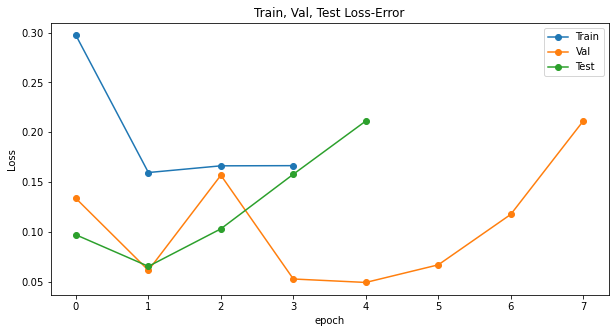

In [20]:
# acc plots
plt.figure(figsize=(10,5))

plt.plot(train_loss, '-o')
plt.plot(val_loss, '-o')
# plt.plot(test_loss, '-o')

plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend(['Train','Val', 'Test'])

plt.title("Train, Val, Test Loss-Error")

plt.show()

# Train Accu

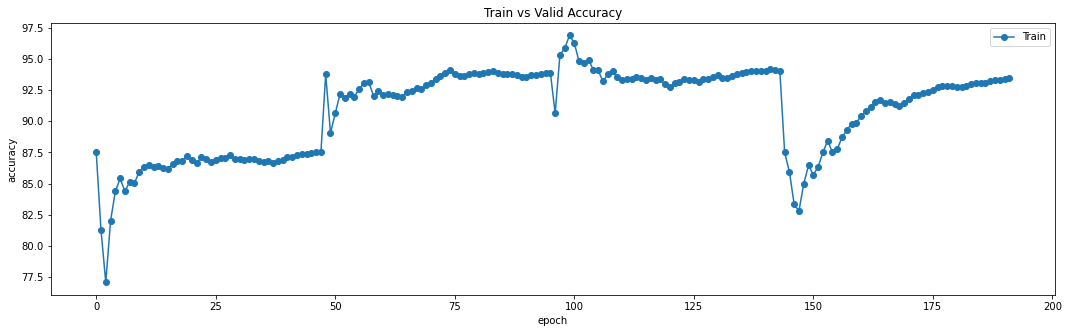

In [21]:
plt.figure(figsize=(18,5))

plt.title('Train vs Valid Accuracy')
plt.plot(train_accuracy,'-o')
# plt.plot(val_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])

plt.show()

# Train, Val accuracy

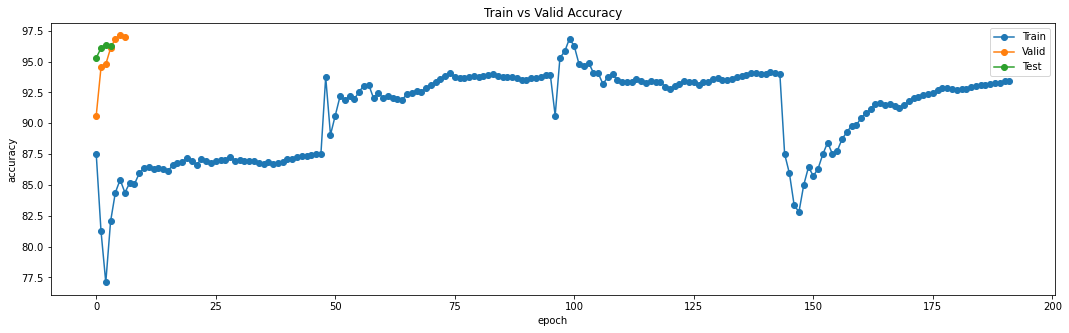

In [22]:
plt.figure(figsize=(18,5))

plt.title('Train vs Valid Accuracy')
plt.plot(train_accuracy,'-o')
plt.plot(val_acc,'-o')
plt.plot(test_acc,'-o')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid', 'Test'])

plt.show()

In [23]:
# meanwhile, here are a few things to know:
# 1. maintain good activity on GitHub, commit everyday
# 2. transfer your code to VS code and commit. Every day there should be a green block
# 3. Join the Slack channel and try to join some existing projects there. 
# Network with some people that already exist in the AI 

# Save model

In [24]:
# Specify a path
PATH = "my_cnn_entire_model.pt"

# Save
torch.save(my_cnn, PATH)

# Load
model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=50176, out_features=3, bias=True)
)

In [39]:


def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for images, labels in valid_loader:
            output = model(images)
            loss = loss_function(output, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)


# Train
def traindata(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    # Early stopping
    last_loss = 100
    patience = 2
    trigger_times = 0

    for epoch in range(1, epochs+1):
        model.train()

        for times, (images, labels) in enumerate(train_loader, 1):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()

            # Show progress
            if times % 100 == 0 or times == len(train_loader):
                print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, times, len(train_loader), loss.item()))

        # Early stopping
        current_loss = validation(model, device, valid_loader, loss_function)
        print('The Current Loss:', current_loss)

        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss

    return model



def test(device, model, test_loader):

    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:

            output = model(images)
            _, predicted = torch.max(output, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy:', correct / total)


def main():
    # GPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print('Device state:', device)


    # Train
    model = traindata(device, 
                      my_cnn, epochs=32, 
                      optimizer=optimizer, 
                      loss_function=loss_function, 
                      train_loader=train_data_loader, valid_loader=val_data_loader  
                     )

    # Test
    test(device, my_cnn, test_data_loader)


if __name__ == '__main__':
    main()

Device state: cpu
[1/32, 48/48] loss: 0.12828165
The Current Loss: 0.269675503884043
trigger times: 0
[2/32, 48/48] loss: 0.022891589
The Current Loss: 0.2116802419934954
trigger times: 0
[3/32, 48/48] loss: 0.16016175
The Current Loss: 0.14570394637329237
trigger times: 0
[4/32, 48/48] loss: 0.097929887
The Current Loss: 0.1812566691743476
Trigger Times: 1
[5/32, 48/48] loss: 0.02069064
The Current Loss: 0.10020741181714195
trigger times: 0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb0addcf280>
Traceback (most recent call last):
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/tesfalemhaile/opt/anaconda3/lib/python3.8/selectors.py", line 415, in select
    fd_